In [1]:
#!pip3 install --upgrade tensorflow

In [2]:
#!pip3 install tensorflow_io

In [3]:
#!pip3 install tensorflow_hub

In [64]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score

In [5]:
tf.__version__

'2.15.0'

## Download the pretraind YAMNet model

In [7]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model        = hub.load(yamnet_model_handle)

In [8]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## Load the data

In [9]:
main_dir = "/WAVE/projects/CSEN-342-Wi24/data/pr3/"

In [10]:
train_dir = main_dir + 'train/'
val_dir   = main_dir + 'val/'
test_dir  = main_dir + 'test/'

In [11]:
train_file_names  = np.array(os.listdir(train_dir))
val_file_names    = np.array(os.listdir(val_dir))

def remove_Non_file(files):
    del_idxs = []
    if 'labels.txt' in files:
        del_idxs.append(np.where(files=='labels.txt')[0][0])
    if '.ipynb_checkpoints' in files:
        del_idxs.append(np.where(files=='.ipynb_checkpoints')[0][0])
    if 'plots' in files:
        del_idxs.append(np.where(files=='plots')[0][0])

    return np.delete(files, del_idxs)

train_file_names = remove_Non_file(train_file_names)
train_file_names.sort()
train_file_names = np.array(map(lambda x:train_dir + x, train_file_names))
val_file_names   = remove_Non_file(val_file_names)
val_file_names.sort()
val_file_names = np.array(map(lambda x:val_dir + x, val_file_names))
df_train = pd.read_csv(train_dir+'labels.txt', names=['label'])
df_train = df_train.apply(lambda x : x-1)
df_train['file'] = train_file_names
df_val = pd.read_csv(val_dir+'labels.txt', names=['label'])
df_val = df_val.apply(lambda x : x-1)
df_val['file'] = val_file_names

df_train.head()

,label,file
0,15,/WAVE/projects/CSEN-342-Wi24/data/pr3/train/00...
1,13,/WAVE/projects/CSEN-342-Wi24/data/pr3/train/00...
2,0,/WAVE/projects/CSEN-342-Wi24/data/pr3/train/00...
3,7,/WAVE/projects/CSEN-342-Wi24/data/pr3/train/00...
4,7,/WAVE/projects/CSEN-342-Wi24/data/pr3/train/00...


In [12]:
test_file_names    = np.array([test_dir + x for x in np.array(os.listdir(test_dir))])
test_file_names.sort()

In [13]:
train_filenames  = df_train['file']
train_targets    = df_train['label']
train_ds = tf.data.Dataset.from_tensor_slices((train_filenames, train_targets))
train_ds.element_spec

val_filenames  = df_val['file']
val_targets    = df_val['label']
val_ds = tf.data.Dataset.from_tensor_slices((val_filenames, val_targets))
val_ds.element_spec

test_ds = tf.data.Dataset.from_tensor_slices((test_file_names))
test_ds.element_spec

TensorSpec(shape=(), dtype=tf.string, name=None)

In [14]:
def load_wav_for_map(filename, label):
  return load_wav_16k_mono(filename), label

train_ds = train_ds.map(load_wav_for_map)
train_ds.element_spec

val_ds   = val_ds.map(load_wav_for_map)
val_ds.element_spec

2024-03-07 17:50:50.544279: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [15]:
def load_wav_for_map(filename):
  return load_wav_16k_mono(filename)

test_ds = test_ds.map(load_wav_for_map)
test_ds.element_spec

TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)

## Extracting embedding using YAMNet for the wav files

In [16]:
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  #embeddings = tf.reshape(embeddings, (1024,1))
  #embeddings = embeddings[..., np.newaxis]
  return (embeddings,
            tf.repeat(label, num_embeddings))

# extract embedding
train_data = train_ds.map(extract_embedding).unbatch()
train_data.element_spec

val_data = val_ds.map(extract_embedding).unbatch()
val_data.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [17]:
def extract_embedding(wav_data):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)

  num_embeddings = tf.shape(embeddings)[0]
  #embeddings = embeddings[..., np.newaxis]
  return (embeddings)

test_data = test_ds.map(extract_embedding)
test_data.element_spec

TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None)

In [18]:
train_data = train_data.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_data   = val_data.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_data  = test_data

## RNN Model Creation

In [30]:
input_shape=(1024,1)
model = tf.keras.Sequential()
model.add(LSTM(128,input_shape=input_shape, return_sequences=True))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(128, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(25, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1024, 128)         66560     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 25)               

In [75]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

In [36]:
# Train model

model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['accuracy'])

rnn_1 = model.fit(train_data, epochs=50,validation_data=val_data, callbacks = [es] )

Epoch 1/50
    109/Unknown - 9s 59ms/step - loss: 1.2963 - accuracy: 0.6032

2024-03-07 18:13:33.536891: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3391086638630507906


110/110 [==============================] - 10s 70ms/step - loss: 1.2953 - accuracy: 0.6031 - val_loss: 1.8579 - val_accuracy: 0.4933
Epoch 2/50
110/110 [==============================] - 7s 65ms/step - loss: 1.2839 - accuracy: 0.6100 - val_loss: 1.7692 - val_accuracy: 0.5293
Epoch 3/50
110/110 [==============================] - 7s 65ms/step - loss: 1.2665 - accuracy: 0.6180 - val_loss: 1.8747 - val_accuracy: 0.5027
Epoch 4/50
110/110 [==============================] - 7s 65ms/step - loss: 1.2368 - accuracy: 0.6203 - val_loss: 1.9196 - val_accuracy: 0.5013
Epoch 5/50
110/110 [==============================] - 7s 65ms/step - loss: 1.2335 - accuracy: 0.6257 - val_loss: 1.8132 - val_accuracy: 0.5000
Epoch 6/50
110/110 [==============================] - 7s 65ms/step - loss: 1.2142 - accuracy: 0.6317 - val_loss: 1.8065 - val_accuracy: 0.5440
Epoch 7/50
110/110 [==============================] - 7s 65ms/step - loss: 1.1838 - accuracy: 0.6403 - val_loss: 1.7900 - val_accuracy: 0.5133
Epoch 8/5

In [79]:
# Visualize loss
def show_plots(model, es):
    loss          = model.history['loss']
    val_loss      = model.history['val_loss']
    stopped_epoch = es#es.stopped_epoch
    
    epochs        = range(stopped_epoch)
    
    plt.figure(figsize=(7,5))
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Loss over epochs', weight='bold', fontsize=22)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(['Training loss', 'Validation loss'], fontsize=16)
    plt.show()

    # Visualize Accuracy
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    #epochs = range(stopped_epoch+1)
    
    plt.figure(figsize=(7,5))
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Accuracy over epochs', weight='bold', fontsize=22)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=16)
    plt.show()

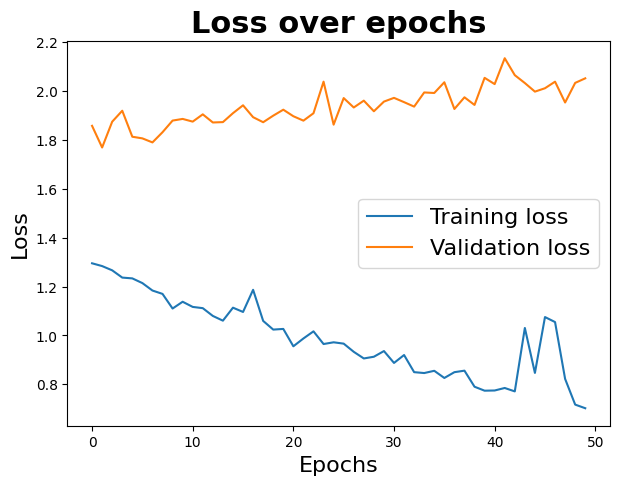

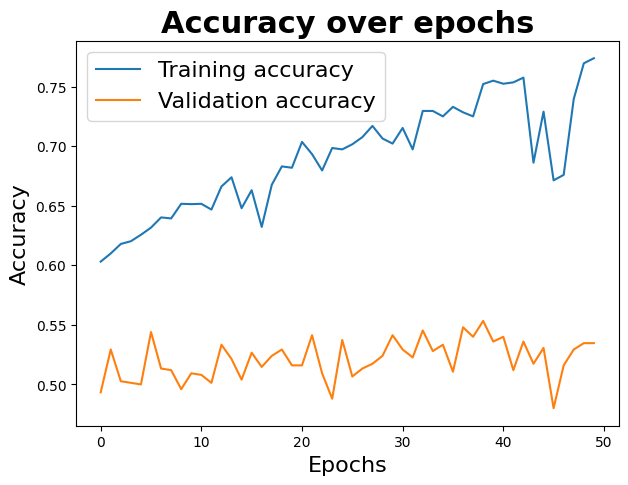

In [51]:
show_plots(rnn_1, es)

### Making Predictions

In [109]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

def save_model(model, path):
    input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
    embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
    _, embeddings_output, _ = embedding_extraction_layer(input_segment)
    serving_outputs = model(embeddings_output)
    serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
    serving_model = tf.keras.Model(input_segment, serving_outputs)
    serving_model.save(saved_model_path, include_optimizer=False)
    print("Model Saved!")
    tf.keras.utils.plot_model(serving_model)

def make_predictions(data, path, validation=True):
    reloaded_model = tf.saved_model.load(saved_model_path)
    res = []
    if validation:
        for i in data['file']:
          sample_file_name = i
          testing_wav_data = load_wav_16k_mono(sample_file_name)
          reloaded_results = reloaded_model(testing_wav_data)
          pred_class = tf.math.argmax(reloaded_results)
          res.append(pred_class.numpy()+1)
        if validation:
            y_true = list(map(lambda x :x+1, data['label'].to_list()))
            y_pred = res
            print("F1 Score on Validation")
            print(f1_score(y_true, y_pred, average='micro'))
    else:
        for i in data:
          sample_file_name = i
          testing_wav_data = load_wav_16k_mono(sample_file_name)
          reloaded_results = reloaded_model(testing_wav_data)
          pred_class = tf.math.argmax(reloaded_results)
          res.append(pred_class.numpy()+1)
            
    return res

In [ ]:
save_model(model, './program3/rnn_1')

In [ ]:
pred_val = make_predictions(df_val, './program3/rnn_1', validation=True)
# F1 Score on Validation
# 0.7733333333333333

In [112]:
pred_test = make_predictions(test_file_names, './program3/rnn_1', validation=False)

In [113]:
pred_test

[17,
 14,
 3,
 25,
 21,
 7,
 11,
 18,
 5,
 16,
 17,
 22,
 14,
 7,
 22,
 18,
 5,
 24,
 1,
 22,
 12,
 20,
 12,
 10,
 1,
 16,
 11,
 10,
 23,
 24,
 3,
 9,
 24,
 4,
 1,
 21,
 2,
 13,
 11,
 12,
 18,
 2,
 1,
 17,
 8,
 22,
 25,
 4,
 14,
 2,
 14,
 19,
 5,
 13,
 6,
 16,
 15,
 16,
 5,
 22,
 24,
 9,
 15,
 8,
 3,
 6,
 23,
 20,
 8,
 19,
 6,
 25,
 14,
 2,
 7]

#### Bidirectional LSTM model

In [68]:
from tensorflow.keras.layers import Bidirectional

In [69]:
input_shape=(1024,1)
model_2 = tf.keras.Sequential()
model_2 = Sequential()
model_2.add(Bidirectional(LSTM(256, return_sequences=True, activation='tanh'),
                             input_shape=input_shape))
model_2.add(Bidirectional(LSTM(128 ,  activation='tanh')))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(25, activation='softmax'))
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1024, 512)         528384    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               656384    
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 25)                1625      
                                                                 
Total params: 1202841 (4.59 MB)
Trainable params: 1202841 (4.59 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_2.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['accuracy'])
rnn_2 = model_2.fit(train_data, epochs=20,validation_data=val_data, callbacks=[es])

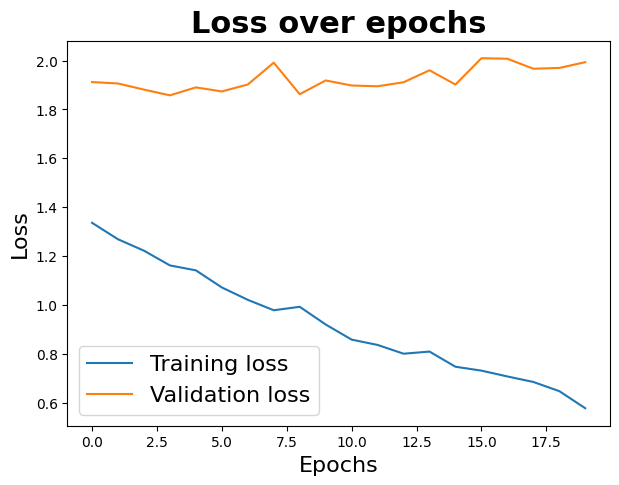

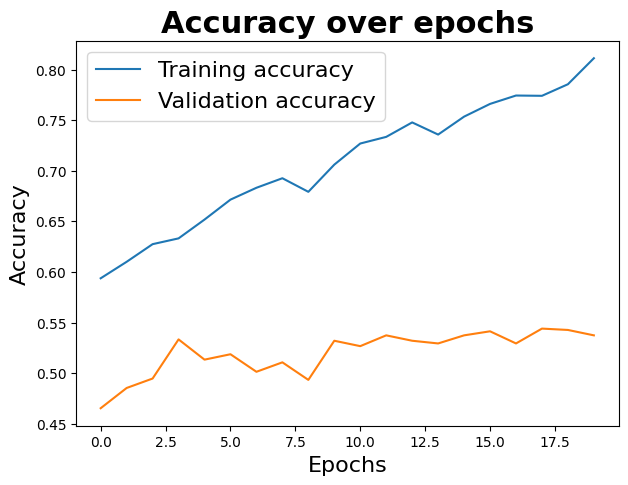

In [80]:
show_plots(rnn_2, 20)

In [106]:
save_model(model_2, './program3/rnn_2')

INFO:tensorflow:Assets written to: ./program3/rnn_1/assets


INFO:tensorflow:Assets written to: ./program3/rnn_1/assets


Model Saved!


In [107]:
pred_val = make_predictions(df_val, './program3/rnn_2', validation=True)

F1 Score on Validation
0.8000000000000002


In [ ]:
pred_test = make_predictions(test_file_names, './program3/rnn_2', validation=False)

In [ ]:
pred_test

## Feature Extraction Using Librosa

In [116]:
#!pip3 install librosa 

In [117]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
from scipy.io import wavfile
import pandas as pd
import numpy as np
import shutil
from tensorflow.keras.utils import to_categorical


%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras import layers
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras
from keras.models import Sequential
import warnings
from tensorflow.keras.metrics import F1Score

In [119]:
sample_file = train_dir + '/00001.wav'
sr = wavfile.read(filename=sample_file)
x, sr = librosa.load(sample_file, sr = sr[0])
ipd.Audio(filename=sample_file, rate=sr)

AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

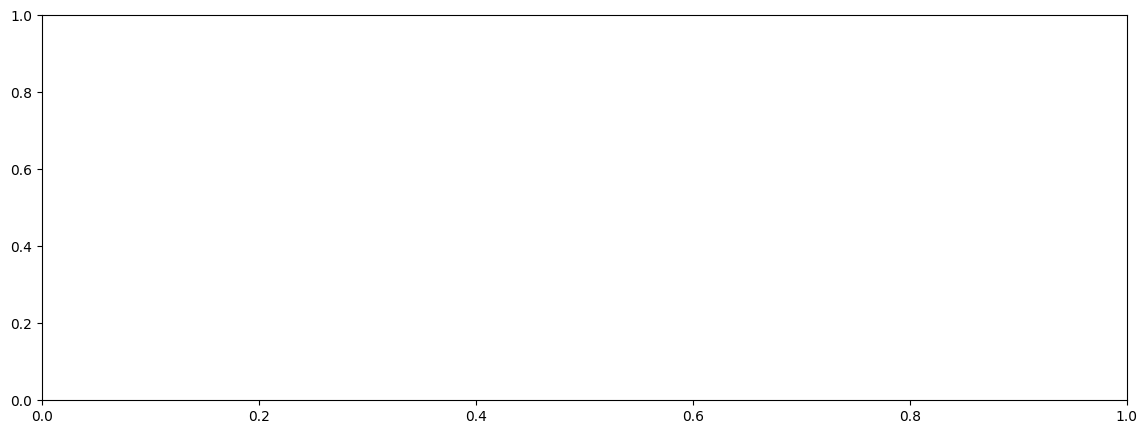

In [120]:
%matplotlib inline

plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

/WAVE/users/unix/npatel2/.local/lib/python3.9/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


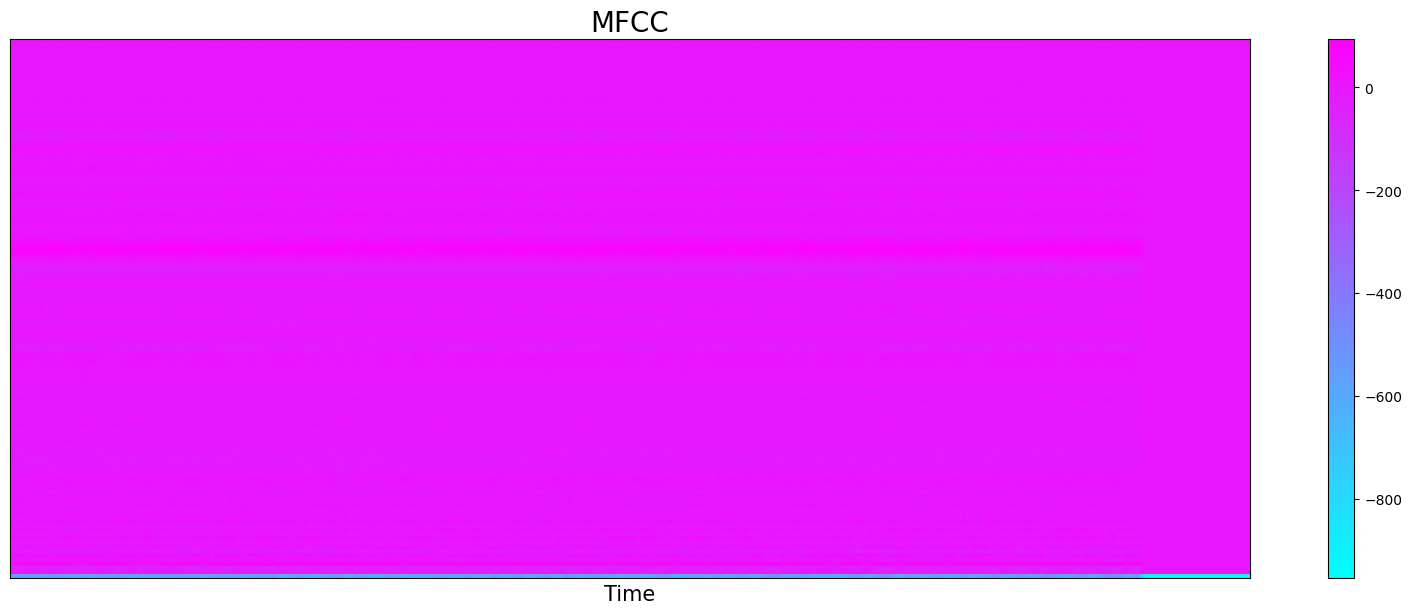

In [121]:
hop_length = 512 #the default spacing between frames
n_fft = 255 #number of samples 
#cut the sample to the relevant times
MFCCs = librosa.feature.mfcc(y=x, n_fft=n_fft,hop_length=hop_length,n_mfcc=128)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(MFCCs,sr=sr, cmap='cool',hop_length=hop_length)
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

In [122]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [125]:
classes_t = list(np.unique(df_train['label']))
len(classes_t)
classes_v = list(np.unique(df_val['label']))
len(classes_v)

25

In [127]:
file = open('./program3/train_dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = classes_t
for g in genres:
    cls_files = df_train['file'][np.where(df_train['label']==g)[0]]
    for filename in cls_files:
        songname    = str(filename)
        y, sr       = librosa.load(songname, sr=sr)
        rmse        = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent   = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw     = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff     = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr         = librosa.feature.zero_crossing_rate(y)
        mfcc        = librosa.feature.mfcc(y=y, sr=sr)
        to_append   = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        
        file = open('./program3/train_dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [128]:
file = open('./program3/val_dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = classes_v
for g in genres:
    cls_files = df_val['file'][np.where(df_val['label']==g)[0]]
    for filename in cls_files:
        songname     = str(filename)
        y, sr        = librosa.load(songname, sr=sr)
        rmse         = librosa.feature.rms(y=y)
        chroma_stft  = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent    = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw      = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff      = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr          = librosa.feature.zero_crossing_rate(y)
        mfcc         = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        
        file = open('./program3/val_dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [130]:
data_t = pd.read_csv('./program3/train_dataset.csv')
data_v = pd.read_csv('./program3/val_dataset.csv')

In [131]:
data_t.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,/WAVE/projects/CSEN-342-Wi24/data/pr3/train/00...,0.358155,0.085268,2656.705174,3761.005208,5979.635613,0.045459,-277.041473,140.334137,7.607147,...,-0.387663,-2.295331,4.114619,-0.785858,9.190955,0.792150,7.250982,-1.403549,-1.083185,0
1,/WAVE/projects/CSEN-342-Wi24/data/pr3/train/00...,0.429617,0.064201,2951.793331,3118.616965,5467.834841,0.086504,-199.292343,148.973984,-52.963902,...,12.502563,0.676627,12.845284,-14.871828,1.399077,-11.904208,0.083296,-14.134049,0.421861,0
2,/WAVE/projects/CSEN-342-Wi24/data/pr3/train/00...,0.493820,0.177345,2956.763702,3004.264507,5739.373029,0.088054,-57.181583,154.397827,-75.293739,...,5.318367,-5.485906,1.727398,-6.478282,-3.858397,-1.299933,-7.416238,1.435634,-4.344321,0
3,/WAVE/projects/CSEN-342-Wi24/data/pr3/train/00...,0.214733,0.271033,4410.555928,4051.643196,8364.425369,0.199469,-30.461212,102.503906,-40.419437,...,2.226820,-11.832220,23.583239,-8.973842,21.120914,7.334766,-2.816680,-0.371591,8.710255,0
4,/WAVE/projects/CSEN-342-Wi24/data/pr3/train/00...,0.264193,0.414236,3425.740373,3942.026194,7906.732390,0.028941,-46.238163,112.473877,-30.874985,...,-7.853868,-9.485129,-2.952578,-14.457929,-12.517904,-8.554135,-7.280069,-9.806058,-6.789524,0


In [132]:
data_v.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,/WAVE/projects/CSEN-342-Wi24/data/pr3/val/0000...,0.541497,0.257811,4348.287066,3842.684585,9184.985295,0.179356,3.414824,100.794418,-56.079475,...,-5.828321,-0.002905,-1.987516,-13.307143,9.564672,-10.113793,-5.002772,-7.800537,1.315662,0
1,/WAVE/projects/CSEN-342-Wi24/data/pr3/val/0003...,0.472686,0.289783,4490.986374,4291.362786,9655.168531,0.128844,26.398592,105.835991,-37.505840,...,8.020569,-8.406511,4.373882,-7.193974,5.554411,-11.451577,0.629297,-10.086552,-0.261667,0
2,/WAVE/projects/CSEN-342-Wi24/data/pr3/val/0006...,0.488275,0.144627,3917.530399,4157.559634,8845.000498,0.101928,-64.863617,127.538727,-29.714449,...,9.386980,-9.835830,6.002550,-8.158251,8.690077,-4.218116,0.632748,-6.593546,-3.429761,0
3,/WAVE/projects/CSEN-342-Wi24/data/pr3/val/0002...,0.424996,0.021870,4242.770151,5834.557048,11515.317530,0.087324,-341.231689,135.277374,1.486508,...,3.031196,9.576129,-4.792517,3.326731,-4.511474,1.821382,-5.630935,-4.232774,-16.354918,1
4,/WAVE/projects/CSEN-342-Wi24/data/pr3/val/0002...,0.661090,0.007078,2814.769133,4137.770983,7162.812681,0.033291,-514.116516,111.397888,25.484434,...,6.384066,4.711816,6.106838,7.090134,4.804109,0.946352,0.764162,3.181929,-1.139009,1


In [192]:
data_v['filename'][:10].to_list()

['/WAVE/projects/CSEN-342-Wi24/data/pr3/val/00009.wav',
 '/WAVE/projects/CSEN-342-Wi24/data/pr3/val/00031.wav',
 '/WAVE/projects/CSEN-342-Wi24/data/pr3/val/00062.wav',
 '/WAVE/projects/CSEN-342-Wi24/data/pr3/val/00023.wav',
 '/WAVE/projects/CSEN-342-Wi24/data/pr3/val/00029.wav',
 '/WAVE/projects/CSEN-342-Wi24/data/pr3/val/00034.wav',
 '/WAVE/projects/CSEN-342-Wi24/data/pr3/val/00024.wav',
 '/WAVE/projects/CSEN-342-Wi24/data/pr3/val/00072.wav',
 '/WAVE/projects/CSEN-342-Wi24/data/pr3/val/00074.wav',
 '/WAVE/projects/CSEN-342-Wi24/data/pr3/val/00008.wav']

In [135]:
def get_training_data(data):
    data        = data.drop(['filename'],axis=1)# Dropping unneccesary columns 
    labels      = data.iloc[:, -1]
    encoder     = LabelEncoder() 
    Y           = encoder.fit_transform(labels)#Encoding the Labels
    scaler      = StandardScaler()
    X           = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float)) #Scaling the Feature columns
    
    return X, Y

In [136]:
X_t, Y_t = get_training_data(data_t)
X_v, Y_v = get_training_data(data_v)

In [143]:
model_3 = Sequential()
model_3.add(layers.Dense(128, activation='relu', input_shape=(X_t.shape[1],)))
#model.add(layers.Dense(128, activation='relu'))
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dense(25, activation='softmax'))
model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               3456      
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 25)                1625      
                                                                 
Total params: 13337 (52.10 KB)
Trainable params: 13337 (52.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
Ann = model_3.fit(X_t,Y_t,
                    epochs=50, shuffle=False, validation_data=(X_v, Y_v))

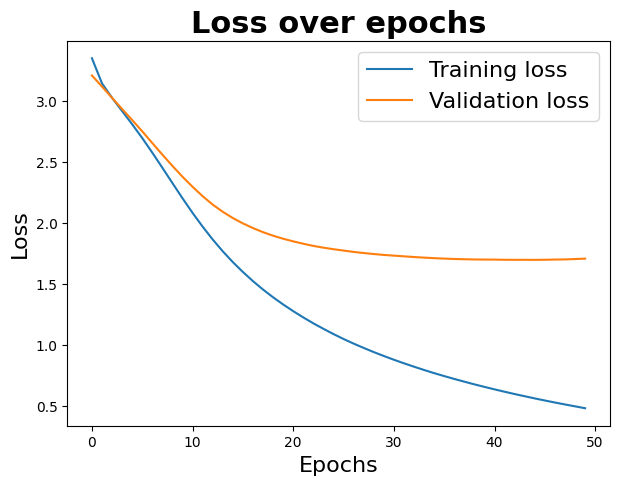

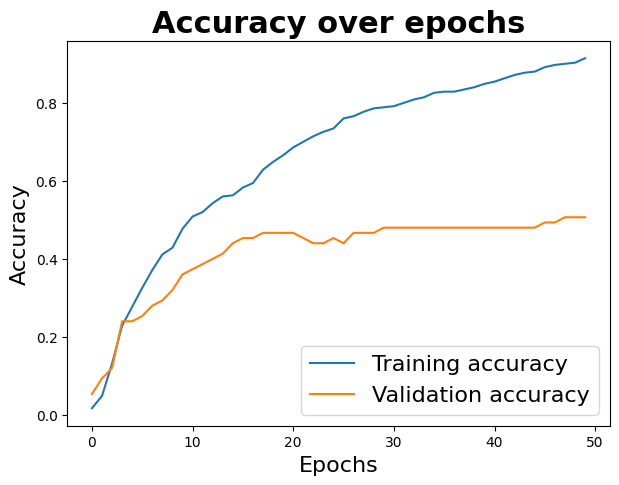

In [145]:
show_plots(Ann, 50)

In [147]:
def get_f1(model, x, y):
    pred = model.predict(x)
    y_pred_ = []
    for i in range(len(pred)):
        y_pred_.append(np.argmax(pred[i])+1)
    print(f1_score(y, y_pred_, average='micro'))
    print(f1_score(y, y_pred_, average='macro'))
    print(f1_score(y, y_pred_, average='weighted'))


get_f1(Ann.model, X_v, Y_v)

3/3 [==============================] - 0s 1ms/step
0.026666666666666672
0.020604395604395608
0.02142857142857143


In [149]:
X_t.shape

(350, 26)

In [153]:
input_shape=(26,1)
model_4 = keras.Sequential()
model_4.add(LSTM(128,input_shape=input_shape, activation='tanh'))
model_4.add(Dropout(0.2))
model_4.add(Dense(128, activation='tanh'))
model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.4))
model_4.add(Dense(25, activation='softmax'))
# model.summary()
model_4.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['accuracy'])

model_4.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 128)               16512     
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 25)                1625      
                                                                 
Total params: 92953 (363.10 KB)
Trainable params: 929

In [ ]:
es_3  = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
rnn_3 = model_4.fit(X_t, Y_t, epochs=500, validation_data=(X_t, Y_t), callbacks=[es_3])

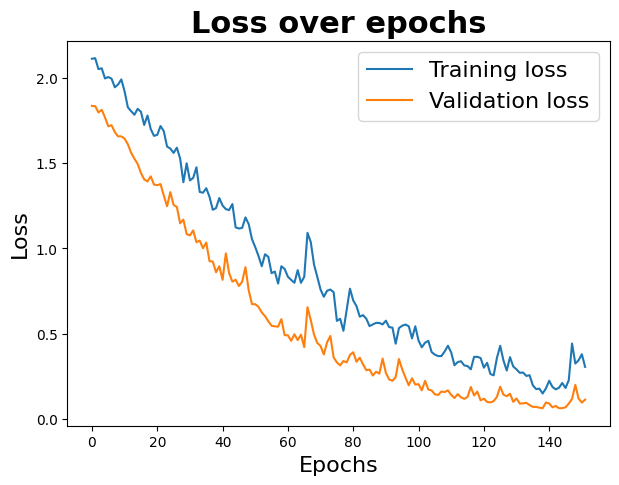

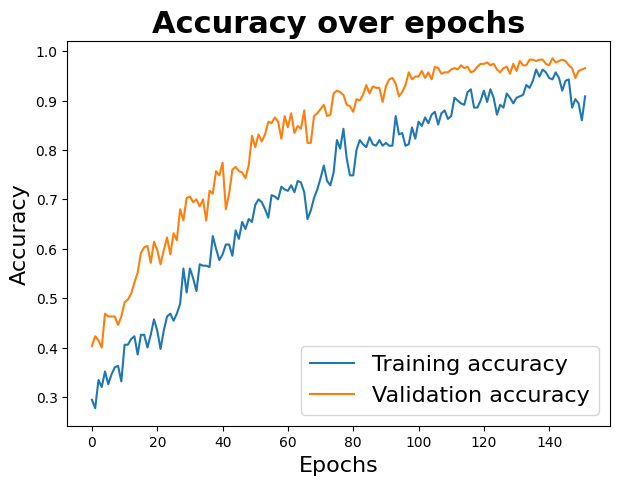

In [157]:
show_plots(rnn_3, 152)

In [165]:
def get_f1(model, x, y):
    pred = model.predict(x)
    y_pred_ = []
    for i in range(len(pred)):
        y_pred_.append(np.argmax(pred[i]))
    print(f1_score(y, y_pred_, average='micro'))
    print(f1_score(y, y_pred_, average='macro'))
    print(f1_score(y, y_pred_, average='weighted'))
    return y_pred_

pred = get_f1(rnn_3.model, X_v, Y_v)

3/3 [==============================] - 0s 2ms/step
0.30666666666666664
0.2935873015873016
0.29358730158730156


In [166]:
Y_v

array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,
        5,  6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11,
       11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16,
       17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22,
       22, 23, 23, 23, 24, 24, 24])

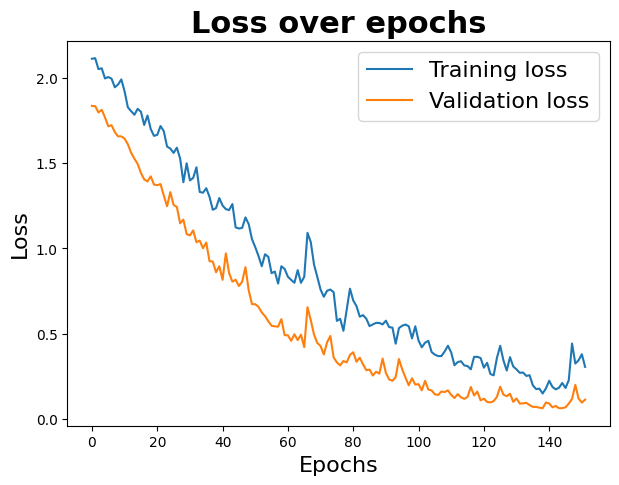

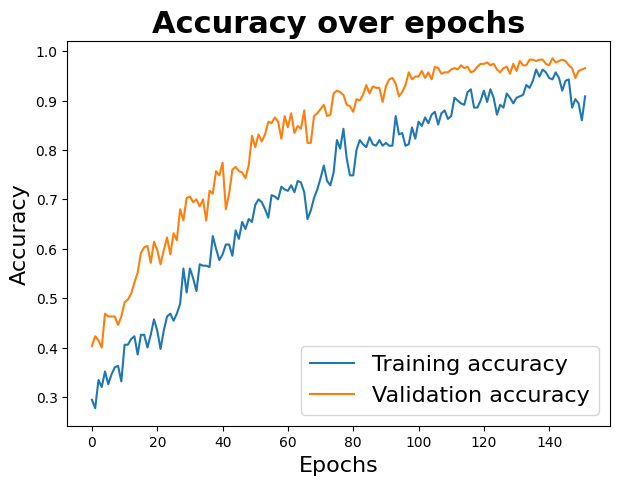

In [170]:
show_plots(rnn_3, es_3.stopped_epoch+1)

### Using only wave MFCC as a features

In [173]:
def get_features(df_in, sr):
    features =[] #list to save features
    labels   =[] #list to save labels
    hop_length = 512 #the default spacing between frames
    n_fft = 255
    for index in range(0,len(df_in)):
        #get the filename        
        filename = df_in.iloc[index]['filename'] 
        species_id = df_in.iloc[index]['label'] 
        #load the file        
        y, sr = librosa.load(filename,sr=sr)
        data = np.array([(librosa.feature.mfcc(y=y, n_fft=n_fft,hop_length=hop_length,n_mfcc=128))])
        features.append(data)
        labels.append(species_id)
    #output = features    
    output=np.concatenate(features,axis=0)
    return(np.array(output), np.array(labels))

X_tf,Y_tf = get_features(data_t, sr)
X_vf, Y_vf = get_features(data_v, sr)

/WAVE/users/unix/npatel2/.local/lib/python3.9/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [174]:
def normalize(X):
    
    X = np.array((X-np.min(X))/(np.max(X)-np.min(X)))
    X = X/np.std(X)
    return X
X_tf = normalize(X_tf)
X_vf = normalize(X_vf)

In [175]:
X_tf.shape

(350, 128, 431)

In [183]:
input_shape=(128,431)
model_5 = tf.keras.Sequential()
model_5 = Sequential()
model_5.add(Bidirectional(LSTM(256, return_sequences=True, activation='tanh'),
                             input_shape=input_shape))
model_5.add(Bidirectional(LSTM(128 ,  activation='tanh')))
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(25, activation='softmax'))
model_5.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['accuracy'])
model_5.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirecti  (None, 128, 512)          1409024   
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)               656384    
 onal)                                                           
                                                                 
 dense_36 (Dense)            (None, 64)                16448     
                                                                 
 dense_37 (Dense)            (None, 25)                1625      
                                                                 
Total params: 2083481 (7.95 MB)
Trainable params: 2083481 (7.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [184]:
es_5  = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

In [185]:
rnn_5 = model_5.fit(X_tf, Y_tf, epochs=50, validation_data=(X_vf, Y_vf), callbacks=[es_5])

Epoch 1/50
11/11 [==============================] - 5s 126ms/step - loss: 3.2697 - accuracy: 0.0229 - val_loss: 3.2266 - val_accuracy: 0.0400
Epoch 2/50
11/11 [==============================] - 0s 36ms/step - loss: 3.2477 - accuracy: 0.0257 - val_loss: 3.2244 - val_accuracy: 0.0400
Epoch 3/50
11/11 [==============================] - 0s 36ms/step - loss: 3.2276 - accuracy: 0.0343 - val_loss: 3.2178 - val_accuracy: 0.0400
Epoch 4/50
11/11 [==============================] - 0s 36ms/step - loss: 3.2210 - accuracy: 0.0486 - val_loss: 3.2181 - val_accuracy: 0.0400
Epoch 5/50
11/11 [==============================] - 0s 36ms/step - loss: 3.2206 - accuracy: 0.0371 - val_loss: 3.2189 - val_accuracy: 0.0000e+00
Epoch 6/50
11/11 [==============================] - 0s 36ms/step - loss: 3.2190 - accuracy: 0.0286 - val_loss: 3.2189 - val_accuracy: 0.0400
Epoch 7/50
11/11 [==============================] - 0s 36ms/step - loss: 3.2190 - accuracy: 0.0400 - val_loss: 3.2189 - val_accuracy: 0.0400
Epoch 8/

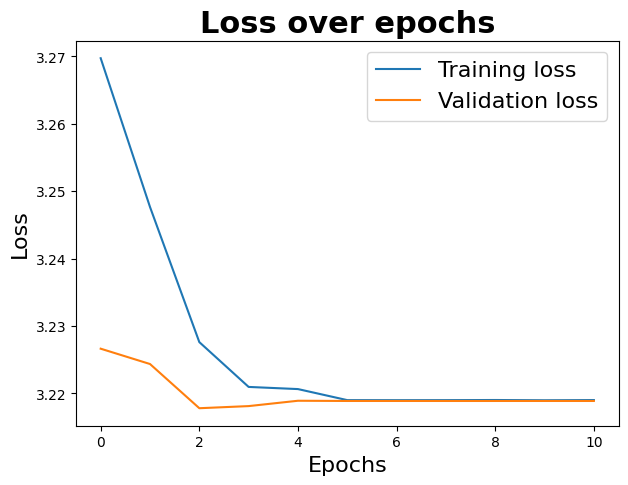

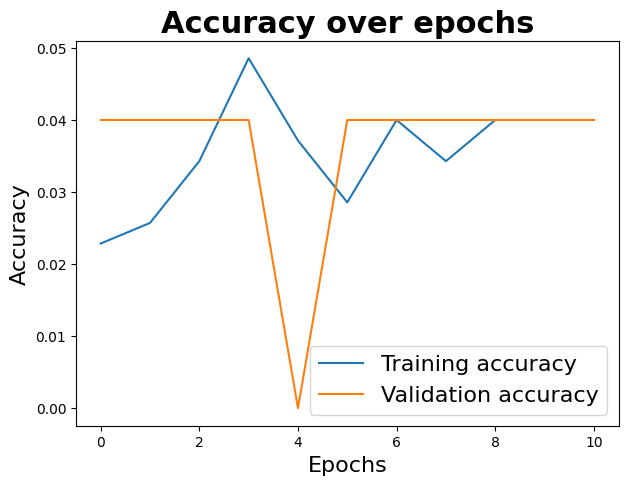

In [187]:
show_plots(rnn_5, es_5.stopped_epoch +1)